## IFT6135 Assignment1, Programming part

Names: Xiao Fan (20086722) ,  Zhibin Lu (20091078)

In [1]:
%pylab inline
import time
import os
import sys
import collections

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms

from_numpy = torch.from_numpy

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
import gzip

Populating the interactive namespace from numpy and matplotlib


# Problem 1
## Building the Model

In [173]:
class MLPnet(nn.Module):

    #todo: init paramater
    def __init__(self,sizes):
        super(MLPnet, self).__init__()

        self.sizes = sizes
        
        self.loss_criterion = nn.NLLLoss()
#         self.loss_criterion = nn.CrossEntropyLoss()
        neu_seq=collections.OrderedDict()
        for i in range(len(sizes)-1):
            neu_seq[str(i*2)]=torch.nn.Linear(self.sizes[i], self.sizes[i+1])
            if i<len(sizes)-2:
                neu_seq[str(i*2+1)]=torch.nn.ReLU()
        neu_seq[str(i*2+1)]=torch.nn.LogSoftmax()
        
        self.mlp_architecture = torch.nn.Sequential(neu_seq)

    def forward(self, x):
        log_proba_out = self.mlp_architecture(x)
        return log_proba_out
        
    def predict(self, proba_out):
#         return np.argmax(proba_out.data.cpu().numpy(),1)
        _,max_ind=proba_out.max(1)
        return max_ind
    
    def loss(self, log_proba_out, target):
        return self.loss_criterion(log_proba_out, target)

    def adjust_lr(self, optimizer, epoch, total_epochs):
        lr = lr0 * (0.1 ** (epoch / float(total_epochs)))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    def init_weights_zero(self,m):
        if type(m) == nn.Linear:
            nn.init.constant(m.weight, 0.0)

    def init_weights_normal(self,m):
        if type(m) == nn.Linear:
            nn.init.normal(m.weight)

    def init_weights_glorot(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform(m.weight)

    def evaluate(self, dataset_loader):
        LOSSES = 0
        COUNTER = 0
        ACCURACY=0
        for batch in dataset_loader:
            # optimizer.zero_grad()
            x, y = batch
            x = Variable(x).view(-1,self.sizes[0])
            y = Variable(y).view(-1)
            if cuda:
                x = x.cuda()
                y = y.cuda()
            
            log_proba_out=self.forward(x)
            loss = self.loss(log_proba_out, y)
            predict_out=self.predict(log_proba_out)

            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n

            COUNTER += n
            ACCURACY+=float(torch.eq(predict_out, y).sum().data.cpu().numpy())
        # get average loss
        return ACCURACY / float(COUNTER) ,LOSSES / float(COUNTER)

    def train_model(self, optim_func, lr, momentum, num_epochs, batch_size, train_data, valid_data=None, test_data=None, display=5):

        LOSSES = 0
        COUNTER = 0
        ITERATIONS = 0
        learning_curve_nll_train = list()
        learning_curve_nll_valid = list()
        learning_curve_nll_test = list()
        learning_curve_acc_train = list()
        learning_curve_acc_valid = list()
        learning_curve_acc_test = list()

        # separate data to mini batchs.
        train_loader = torch.utils.data.DataLoader(
                train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        if valid_data is not None:
            valid_loader = torch.utils.data.DataLoader(
                valid_data, batch_size=batch_size, shuffle=True, num_workers=2)        
        if test_data is not None:
            test_loader = torch.utils.data.DataLoader(
                test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        

        #training
        print('Training Begining, Count of batchs:',len(train_loader))

        optimizer=optim_func(self.parameters(), lr, momentum)

        # trainloss_every = 200
        for ep in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
                x = Variable(x).view(-1,self.sizes[0])
                y = Variable(y).view(-1)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                    
                log_proba_out=self.forward(x)
                loss = self.loss(log_proba_out, y)
                loss.backward()
                optimizer.step()
            
            # record loss values and accuray values
            train_acc,train_loss = self.evaluate(train_loader)
            learning_curve_nll_train.append(train_loss)
            learning_curve_acc_train.append(train_acc)
            if valid_data is not None:
                valid_acc,valid_loss = self.evaluate(valid_loader)
                learning_curve_nll_valid.append(valid_loss)
                learning_curve_acc_valid.append(valid_acc)
            if test_data is not None:
                test_acc,test_loss = self.evaluate(test_loader)
                learning_curve_nll_test.append(test_loss)
                learning_curve_acc_test.append(test_acc)

            # print the process of the training.  
            if display!=0 and (ep % display==0 or ep==(num_epochs-1)):
                if valid_data is None:
                    valid_loss=0
                    valid_acc=0
                if test_data is None:
                    test_loss=0
                    test_acc=0
                print("Epoch:{}, [NLL] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_loss, valid_loss, test_loss))
                print("Epoch:{}, [ACC] TRAIN {} / VALID {} / TEST {}".format(ep+1,
                    train_acc, valid_acc, test_acc))
            
            self.adjust_lr(optimizer, ep+1, num_epochs)
            
        return learning_curve_nll_train, \
            learning_curve_nll_valid, \
            learning_curve_nll_test, \
            learning_curve_acc_train, \
            learning_curve_acc_valid,\
            learning_curve_acc_test


    # train method for problem2--variance in training
    def train_model2(self, optim_func, lr, momentum, num_epochs, batch_size, train_data, valid_data=None, test_data=None, display=5, record_forupdates=5000):

        learning_curve_nll_train = list()

        # separate data to mini batchs.
        train_loader = torch.utils.data.DataLoader(
                train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        if valid_data is not None:
            valid_loader = torch.utils.data.DataLoader(
                valid_data, batch_size=batch_size, shuffle=True, num_workers=2)        
        if test_data is not None:
            test_loader = torch.utils.data.DataLoader(
                test_data, batch_size=batch_size, shuffle=True, num_workers=2)
        

        #training
        print('Training Begining, Count of batchs:',len(train_loader))

        optimizer=optim_func(self.parameters(), lr, momentum)

        ITERATIONS = 1
        for ep in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                x, y = batch
                x = Variable(x).view(-1,self.sizes[0])
                y = Variable(y).view(-1)
                if cuda:
                    x = x.cuda()
                    y = y.cuda()
                    
                log_proba_out=self.forward(x)
                loss = self.loss(log_proba_out, y)

                learning_curve_nll_train.append(loss.data[0])

                if display!=0 and ITERATIONS % display==0:
                    print("Update:{}, [NLL] TRAIN {} .".format(ITERATIONS,
                        loss.data[0]))

                loss.backward()
                optimizer.step()

                if ITERATIONS>=record_forupdates:
                    return learning_curve_nll_train

                ITERATIONS += 1
                

            self.adjust_lr(optimizer, ep+1, num_epochs)
            
        return learning_curve_nll_train



## Load MNIST dataset

In [3]:
print('Load MNIST data:')
# Pour l'ensemble de donnees de mnist
f_mnist=gzip.open('datasets/mnist.pkl.gz')
f=gzip.open('datasets/mnist.pkl.gz')
mnistdata=pickle.load(f)
f.close()
mnist_train_inputs=mnistdata[0][0]
mnist_train_labels=mnistdata[0][1]
mnist_valid_inputs=mnistdata[1][0]
mnist_valid_labels=mnistdata[1][1]
mnist_test_inputs=mnistdata[2][0]
mnist_test_labels=mnistdata[2][1]
mnist_train_data = torch.utils.data.TensorDataset(
    torch.from_numpy(mnist_train_inputs),torch.from_numpy(mnist_train_labels))
mnist_valid_data = torch.utils.data.TensorDataset(
    torch.from_numpy(mnist_valid_inputs),torch.from_numpy(mnist_valid_labels))
mnist_test_data = torch.utils.data.TensorDataset(
    torch.from_numpy(mnist_test_inputs),torch.from_numpy(mnist_test_labels))

print('mnist_train:',len(mnist_train_data))
print('mnist_valid:',len(mnist_valid_data))
print('mnist_test:',len(mnist_test_data))

Load MNIST data:
('mnist_train:', 50000)
('mnist_valid:', 10000)
('mnist_test:', 10000)


## Hyper-parameters and create model

In [12]:
sizes=[784,600,300,10]
num_epochs = 10
batch_size = 64
lr0 = 0.02
momentum=0.0
cuda = False

#define mlp net
model1 = MLPnet(sizes)
if cuda:
    model1 = model1.cuda()

## Initialization

In [14]:
# zero initialization
model1.apply(model1.init_weights_zero)
ll_train_zero,ll_valid_zero,ll_test_zero,acc_train_zero,acc_valid_zero,acc_test_zero= \
    model1.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, mnist_train_data,
        mnist_valid_data,mnist_test_data, 3)

('Training Begining, Count of batchs:', 782)
Epoch:1, [NLL] TRAIN [ 2.30102563] / VALID [ 2.30210352] / TEST [ 2.30102634]
Epoch:1, [ACC] TRAIN 0.11356 / VALID 0.1064 / TEST 0.1135
Epoch:4, [NLL] TRAIN [ 2.30101228] / VALID [ 2.30202317] / TEST [ 2.3009882]
Epoch:4, [ACC] TRAIN 0.11356 / VALID 0.1064 / TEST 0.1135
Epoch:7, [NLL] TRAIN [ 2.30101085] / VALID [ 2.30199671] / TEST [ 2.30101371]
Epoch:7, [ACC] TRAIN 0.11356 / VALID 0.1064 / TEST 0.1135
Epoch:10, [NLL] TRAIN [ 2.3010118] / VALID [ 2.30198503] / TEST [ 2.30100203]
Epoch:10, [ACC] TRAIN 0.11356 / VALID 0.1064 / TEST 0.1135


In [16]:
# normal initialization
model1.apply(model1.init_weights_normal)
ll_train_normal,ll_valid_normal,ll_test_normal,acc_train_normal,acc_valid_normal,acc_test_normal=\
    model1.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, mnist_train_data,
        mnist_valid_data,mnist_test_data, 3)

('Training Begining, Count of batchs:', 782)
Epoch:1, [NLL] TRAIN [ 2.17776299] / VALID [ 2.2764349] / TEST [ 2.45880008]
Epoch:1, [ACC] TRAIN 0.55976 / VALID 0.5844 / TEST 0.5559
Epoch:4, [NLL] TRAIN [ 1.16753042] / VALID [ 1.42142439] / TEST [ 1.62288463]
Epoch:4, [ACC] TRAIN 0.6776 / VALID 0.6909 / TEST 0.6691
Epoch:7, [NLL] TRAIN [ 0.96213007] / VALID [ 1.26720858] / TEST [ 1.47153616]
Epoch:7, [ACC] TRAIN 0.72098 / VALID 0.7277 / TEST 0.7083
Epoch:10, [NLL] TRAIN [ 0.87430602] / VALID [ 1.1853689] / TEST [ 1.40012455]
Epoch:10, [ACC] TRAIN 0.74156 / VALID 0.7522 / TEST 0.733


In [17]:
# Glorot initialization
model1.apply(model1.init_weights_glorot)
ll_train_glorot,ll_valid_glorot,ll_test_glorot,acc_train_glorot,acc_valid_glorot,acc_test_glorot=\
    model1.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, mnist_train_data,
        mnist_valid_data,mnist_test_data, 3)

('Training Begining, Count of batchs:', 782)
Epoch:1, [NLL] TRAIN [ 0.3689456] / VALID [ 0.34263855] / TEST [ 0.35018483]
Epoch:1, [ACC] TRAIN 0.88884 / VALID 0.9006 / TEST 0.8952
Epoch:4, [NLL] TRAIN [ 0.23539387] / VALID [ 0.22501081] / TEST [ 0.23035681]
Epoch:4, [ACC] TRAIN 0.93262 / VALID 0.9363 / TEST 0.935
Epoch:7, [NLL] TRAIN [ 0.20508926] / VALID [ 0.19888794] / TEST [ 0.2044044]
Epoch:7, [ACC] TRAIN 0.94068 / VALID 0.945 / TEST 0.9417
Epoch:10, [NLL] TRAIN [ 0.19046761] / VALID [ 0.18618298] / TEST [ 0.1935358]
Epoch:10, [ACC] TRAIN 0.9453 / VALID 0.9493 / TEST 0.9461


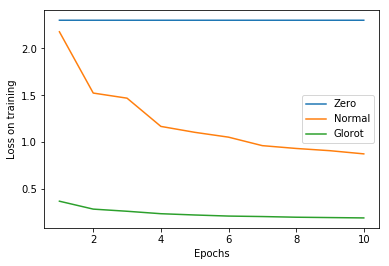

In [18]:
plt.figure()
plt.plot(range(1,num_epochs+1),ll_train_zero,label='Zero')
plt.plot(range(1,num_epochs+1),ll_train_normal,label='Normal')
plt.plot(range(1,num_epochs+1),ll_train_glorot,label='Glorot')
plt.xlabel('Epochs')
plt.ylabel('Loss on training')
plt.legend()
plt.savefig('problem1-init.pdf')
plt.show()

## Learning Curves

In [38]:
#set hyper parameters
sizes=[784,600,100,10]
batch_size = 64
num_epochs = 100
cuda = False
lr0 = 0.02
momentum=0.0

#define mlp net
model1 = MLPnet(sizes)

model1.apply(model1.init_weights_glorot)
ll_train_glorot,ll_valid_glorot,ll_test_glorot,acc_train_glorot,acc_valid_glorot,acc_test_glorot=\
    model1.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, mnist_train_data,
        mnist_valid_data,mnist_test_data,20)


('Training Begining, Count of batchs:', 782)
Epoch:1, [NLL] TRAIN [ 0.31661138] / VALID [ 0.29322472] / TEST [ 0.29969409]
Epoch:1, [ACC] TRAIN 0.91222 / VALID 0.9181 / TEST 0.9174
Epoch:21, [NLL] TRAIN [ 0.05100355] / VALID [ 0.08552448] / TEST [ 0.08610594]
Epoch:21, [ACC] TRAIN 0.98712 / VALID 0.9751 / TEST 0.9737
Epoch:41, [NLL] TRAIN [ 0.0259389] / VALID [ 0.07394009] / TEST [ 0.07261139]
Epoch:41, [ACC] TRAIN 0.99504 / VALID 0.9792 / TEST 0.9764
Epoch:61, [NLL] TRAIN [ 0.01745208] / VALID [ 0.07181744] / TEST [ 0.06946559]
Epoch:61, [ACC] TRAIN 0.99776 / VALID 0.9796 / TEST 0.9771
Epoch:81, [NLL] TRAIN [ 0.01402876] / VALID [ 0.07160164] / TEST [ 0.06866954]
Epoch:81, [ACC] TRAIN 0.9985 / VALID 0.9801 / TEST 0.9768
Epoch:100, [NLL] TRAIN [ 0.01232926] / VALID [ 0.07136255] / TEST [ 0.06839257]
Epoch:100, [ACC] TRAIN 0.9988 / VALID 0.9802 / TEST 0.977


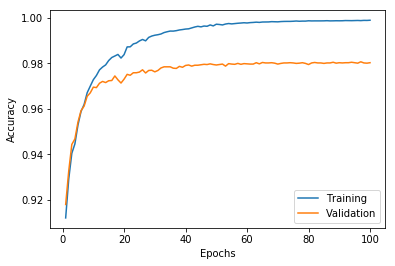

In [39]:
# plot accuracy against the training time
plt.figure()
plt.plot(range(1,num_epochs+1),acc_train_glorot,label='Training')
plt.plot(range(1,num_epochs+1),acc_valid_glorot,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('problem1-accuracy1.pdf')
plt.show()

### Double capacity

In [27]:
num_epochs = 100
sizes=[784,800,400,10]
model1 = MLPnet(sizes)
model1.apply(model1.init_weights_glorot)
ll_train_glorot2,ll_valid_glorot2,ll_test_glorot2,acc_train_glorot2,acc_valid_glorot2,acc_test_glorot2=\
    model1.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, mnist_train_data,
        mnist_valid_data,mnist_test_data, 10)


('Training Begining, Count of batchs:', 782)
Epoch:1, [NLL] TRAIN [ 0.32770947] / VALID [ 0.30197799] / TEST [ 0.30822513]
Epoch:1, [ACC] TRAIN 0.9066 / VALID 0.9178 / TEST 0.9123
Epoch:11, [NLL] TRAIN [ 0.09289576] / VALID [ 0.11241861] / TEST [ 0.10989171]
Epoch:11, [ACC] TRAIN 0.97454 / VALID 0.969 / TEST 0.9665
Epoch:21, [NLL] TRAIN [ 0.05226662] / VALID [ 0.08951543] / TEST [ 0.08304434]
Epoch:21, [ACC] TRAIN 0.98656 / VALID 0.9746 / TEST 0.974
Epoch:31, [NLL] TRAIN [ 0.0344952] / VALID [ 0.08079372] / TEST [ 0.07345305]
Epoch:31, [ACC] TRAIN 0.99244 / VALID 0.9763 / TEST 0.9776
Epoch:41, [NLL] TRAIN [ 0.02528276] / VALID [ 0.07666276] / TEST [ 0.06817023]
Epoch:41, [ACC] TRAIN 0.99546 / VALID 0.9784 / TEST 0.9791
Epoch:51, [NLL] TRAIN [ 0.02017495] / VALID [ 0.07489219] / TEST [ 0.06667338]
Epoch:51, [ACC] TRAIN 0.99708 / VALID 0.979 / TEST 0.9791
Epoch:61, [NLL] TRAIN [ 0.01709339] / VALID [ 0.07480209] / TEST [ 0.06573427]
Epoch:61, [ACC] TRAIN 0.99784 / VALID 0.979 / TEST 0.97

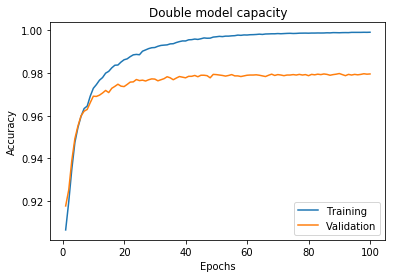

In [28]:
# plot accuracy against the training time
plt.figure()
plt.plot(range(1,num_epochs+1),acc_train_glorot2,label='Training')
plt.plot(range(1,num_epochs+1),acc_valid_glorot2,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Double model capacity')
plt.legend()
plt.savefig('problem1-accuracy2.pdf')
plt.show()

## Training Set Size, Generalization Gap, and Standard Error

In [40]:
sizes=[784,600,100,10]
list_a = [0.01,0.02,0.05,0.1,1]
num_epochs = 100
N = 50000
result = np.zeros((len(list_a),5))
for a in range(len(list_a)) :
    for i in range(5) : 
        Na = int (list_a[a]*N)
        index = np.random.choice(N,Na)
        mnist_train_subinputs = mnist_train_inputs[index,:]
        mnist_train_sublabels = mnist_train_labels[index]
        mnist_train_subdata = torch.utils.data.TensorDataset(
            torch.from_numpy(mnist_train_subinputs),torch.from_numpy(mnist_train_sublabels))
#        print "training set size : ", len(mnist_train_subdata)
        model1 = MLPnet(sizes)
        model1.apply(model1.init_weights_glorot)
        ll_train_sub,ll_valid_sub,ll_test_sub,acc_train_sub,acc_valid_sub,acc_test_sub=\
            model1.train_model(torch.optim.SGD, lr0, momentum, 
            num_epochs, batch_size, mnist_train_subdata,
            mnist_valid_data,mnist_test_data, False)
        
        best = np.argmax(acc_valid_sub)
        diff = acc_train_sub[best] - acc_test_sub[best]
        result[a][i] = diff
        

('Training Begining, Count of batchs:', 8)
('Training Begining, Count of batchs:', 8)
('Training Begining, Count of batchs:', 8)
('Training Begining, Count of batchs:', 8)
('Training Begining, Count of batchs:', 8)
('Training Begining, Count of batchs:', 16)
('Training Begining, Count of batchs:', 16)
('Training Begining, Count of batchs:', 16)
('Training Begining, Count of batchs:', 16)
('Training Begining, Count of batchs:', 16)
('Training Begining, Count of batchs:', 40)
('Training Begining, Count of batchs:', 40)
('Training Begining, Count of batchs:', 40)
('Training Begining, Count of batchs:', 40)
('Training Begining, Count of batchs:', 40)
('Training Begining, Count of batchs:', 79)
('Training Begining, Count of batchs:', 79)
('Training Begining, Count of batchs:', 79)
('Training Begining, Count of batchs:', 79)
('Training Begining, Count of batchs:', 79)
('Training Begining, Count of batchs:', 782)
('Training Begining, Count of batchs:', 782)
('Training Begining, Count of batch

In [42]:
print result      
 
avg_gap = np.mean(result,axis = 1)    
std_gap = np.std(result,axis = 1)
for a in range(len(list_a)) :
    print ("training set size {}, average generalization gap {}, standard error {}".format(list_a[a]*N,avg_gap[a],std_gap[a]))
    

[[ 0.1264   0.1087   0.1198   0.0771   0.0971 ]
 [ 0.0808   0.0925   0.0824   0.082    0.0827 ]
 [ 0.0585   0.0566   0.0593   0.0605   0.0561 ]
 [ 0.0479   0.0542   0.0499   0.055    0.0444 ]
 [ 0.02428  0.02382  0.02356  0.02318  0.02408]]
training set size 500.0, average generalization gap 0.10582, standard error 0.0174822652994
training set size 1000.0, average generalization gap 0.08408, standard error 0.00425929571643
training set size 2500.0, average generalization gap 0.0582, standard error 0.00164681510802
training set size 5000.0, average generalization gap 0.05028, standard error 0.00395039238557
training set size 50000, average generalization gap 0.023784, standard error 0.000387277678159


# Problem 2

In [41]:
print('Load Corpus data:')
news_train_inputs_o=  np.loadtxt('20news-bydate/matlab/train.data')
news_train_labels_o=  np.loadtxt('20news-bydate/matlab/train.label')
news_test_inputs_o =  np.loadtxt('20news-bydate/matlab/test.data')
news_test_labels_o =  np.loadtxt('20news-bydate/matlab/test.label')
# print(news_train_inputs.shape)
# print(news_train_labels.shape)
# print(news_test_inputs.shape)
# print(news_test_labels.shape)

type_max=int(np.max([np.max(news_train_inputs_o[:,1]),np.max(news_test_inputs_o[:,1])]))
num_class=int(np.max(news_train_labels_o))

def constructVectors(inputs):
    doc_max=int(np.max(inputs[:,0]))
    data=torch.zeros(doc_max,type_max)
    for w in inputs:
        data[w[0]-1,w[1]-1]=w[2]
    return data

news_train_inputs= constructVectors(news_train_inputs_o)
news_test_inputs = constructVectors(news_test_inputs_o)
news_train_labels=torch.from_numpy(news_train_labels_o-1).int()
news_test_labels=torch.from_numpy(news_test_labels_o-1).int()

ind_separate=news_train_inputs.size(0)/5
np.random.seed(456)
indexs = np.arange(0,news_train_inputs.size(0))
np.random.shuffle(indexs)
news_valid_inputs = news_train_inputs[indexs[:ind_separate]]
news_valid_labels = news_train_labels[indexs[:ind_separate]]
news_train_inputs  = news_train_inputs[indexs[ind_separate:]]
news_train_labels  = news_train_labels[indexs[ind_separate:]]

print('max index of types:',type_max)
print('number of class:',num_class)

del news_train_inputs_o,news_train_labels_o,news_test_inputs_o,news_test_labels_o
gc.collect()

Load Corpus data:
('max index of types:', 61188)
('number of class:', 20)


12

In [44]:
print news_train_inputs.shape
print news_valid_inputs.shape
print news_test_inputs.shape

torch.Size([9016, 61188])
torch.Size([2253, 61188])
torch.Size([7505, 61188])


## Building the model
### No preprocessing

In [58]:
# preprocess the data for NO-Preprocessing
news_train_data  = torch.utils.data.TensorDataset(
    news_train_inputs,news_train_labels)
news_valid_data = torch.utils.data.TensorDataset(
    news_valid_inputs,news_valid_labels)
news_test_data = torch.utils.data.TensorDataset(
    news_test_inputs,news_test_labels)

print('news_train:',len(news_train_data))
print('news_valid:',len(news_valid_data))
print('news_test:',len(news_test_data))


('news_train:', 9016)
('news_valid:', 2253)
('news_test:', 7505)


In [115]:
#set hyper parameters
sizes=[type_max,100,num_class]
momentum=0.9
cuda = False
num_epochs = 20

#define mlp net
model2 = MLPnet(sizes)
if cuda:
    model2 = model2.cuda()

lr0 = 0.01
batch_size = 64
model2.apply(model2.init_weights_glorot)
ll_train,ll_valid,ll_test,acc_train,acc_valid,acc_test=\
    model2.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, news_train_data,
        news_valid_data,news_test_data,display=5)
# Epoch:20, [ACC] TRAIN 0.963287488909 / VALID 0.827341322681 / TEST 0.714057295137 lr = 0.01
# Epoch:20, [ACC] TRAIN 0.968389529725 / VALID 0.812250332889 / TEST 0.712191872085 lr - 0.02
# Epoch:20, [ACC] TRAIN 0.933340727595 / VALID 0.760763426542 / TEST 0.661425716189 lr=0.05
# Epoch:20, [ACC] TRAIN 0.922582076309 / VALID 0.803817132712 / TEST 0.704463690873 lr = 0.005

('Training Begining, Count of batchs:', 141)
Epoch:1, [NLL] TRAIN [ 2.79522872] / VALID [ 2.82018995] / TEST [ 2.82533097]
Epoch:1, [ACC] TRAIN 0.184228039042 / VALID 0.164669329783 / TEST 0.162158560959
Epoch:6, [NLL] TRAIN [ 0.76684618] / VALID [ 1.09857678] / TEST [ 1.37009716]
Epoch:6, [ACC] TRAIN 0.839174800355 / VALID 0.732356857523 / TEST 0.648634243837
Epoch:11, [NLL] TRAIN [ 0.89346731] / VALID [ 1.35050559] / TEST [ 1.77863693]
Epoch:11, [ACC] TRAIN 0.840505767524 / VALID 0.72614292055 / TEST 0.642504996669
Epoch:16, [NLL] TRAIN [ 0.34153548] / VALID [ 0.82713085] / TEST [ 1.18867815]
Epoch:16, [ACC] TRAIN 0.946095829636 / VALID 0.818464269862 / TEST 0.711125916056
Epoch:20, [NLL] TRAIN [ 0.30633903] / VALID [ 0.81419712] / TEST [ 1.18984973]
Epoch:20, [ACC] TRAIN 0.955190771961 / VALID 0.823790501553 / TEST 0.712858094604


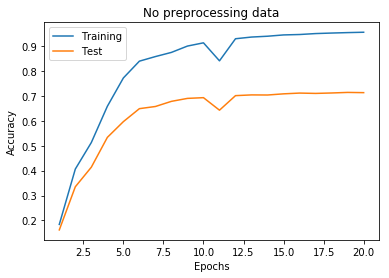

In [118]:
# plot accuracy against training time
plt.figure()
plt.plot(range(1,num_epochs+1),acc_train,label='Training')
# plt.plot(range(1,num_epochs+1),acc_valid,label='Validation')
plt.plot(range(1,num_epochs+1),acc_test,label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('No preprocessing data')
plt.legend()
plt.savefig('problem2-no-preprocessing.pdf')
plt.show()

## IF-IDF

In [70]:
# tf-idf:
from sklearn.feature_extraction.text import TfidfTransformer

#preprocess the data to tf-idf
TfidfTransf=TfidfTransformer()
TfidfTransf.fit(news_train_inputs.numpy())

tfidf_train_inputs=torch.from_numpy(TfidfTransf.transform(
    news_train_inputs.numpy()).toarray()).type(torch.FloatTensor)
tfidf_valid_inputs=torch.from_numpy(TfidfTransf.transform(
    news_valid_inputs.numpy()).toarray()).type(torch.FloatTensor)
tfidf_test_inputs=torch.from_numpy(TfidfTransf.transform(
    news_test_inputs.numpy()).toarray()).type(torch.FloatTensor)

tfidf_train_data  = torch.utils.data.TensorDataset(
    tfidf_train_inputs,news_train_labels)
tfidf_valid_data = torch.utils.data.TensorDataset(
    tfidf_valid_inputs,news_valid_labels)
tfidf_test_data = torch.utils.data.TensorDataset(
    tfidf_test_inputs,news_test_labels)

print('tfidf_train:',len(tfidf_train_data))
print('tfidf_valid:',len(tfidf_valid_data))
print('tfidf_test:',len(tfidf_test_data))

('tfidf_train:', 9016)
('tfidf_valid:', 2253)
('tfidf_test:', 7505)


In [131]:
# train the model
sizes=[type_max,100,num_class]
momentum=0.9
num_epochs = 20
lr0 = 0.09
batch_size = 64

model2 = MLPnet(sizes)
model2.apply(model2.init_weights_glorot)
ll_train2,ll_valid2,ll_test2,acc_train2,acc_valid2,acc_test2=\
    model2.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, tfidf_train_data,
        tfidf_valid_data,tfidf_test_data,display=5)

# Epoch:20, [ACC] TRAIN 0.625554569654 / VALID 0.575676875277 / TEST 0.526715522985 lr = 0.01
# Epoch:20, [ACC] TRAIN 0.934671694765 / VALID 0.832667554372 / TEST 0.763890739507 lr = 0.05
# Epoch:20, [ACC] TRAIN 0.977817213842 / VALID 0.864181091877 / TEST 0.778814123917 lr = 0.07
# Epoch:20, [ACC] TRAIN 0.987023070098 / VALID 0.876608965823 / TEST 0.786942038641 lr = 0.08
# Epoch:20, [ACC] TRAIN 0.993234250222 / VALID 0.880159786951 / TEST 0.786009327115 lr = 0.09
# Epoch:20, [ACC] TRAIN 0.994787045253 / VALID 0.877940523746 / TEST 0.790273151233 lr 0.1

('Training Begining, Count of batchs:', 141)
Epoch:1, [NLL] TRAIN [ 2.82458091] / VALID [ 2.83488202] / TEST [ 2.85373354]
Epoch:1, [ACC] TRAIN 0.174245785271 / VALID 0.171327119396 / TEST 0.144437041972
Epoch:6, [NLL] TRAIN [ 0.60551864] / VALID [ 0.87758493] / TEST [ 1.07735598]
Epoch:6, [ACC] TRAIN 0.919698314108 / VALID 0.821127385708 / TEST 0.752564956696
Epoch:11, [NLL] TRAIN [ 0.27348161] / VALID [ 0.62783968] / TEST [ 0.86944455]
Epoch:11, [ACC] TRAIN 0.975044365572 / VALID 0.861517976032 / TEST 0.770952698201
Epoch:16, [NLL] TRAIN [ 0.18106084] / VALID [ 0.55645478] / TEST [ 0.80905664]
Epoch:16, [ACC] TRAIN 0.988132209406 / VALID 0.876608965823 / TEST 0.787475016656
Epoch:20, [NLL] TRAIN [ 0.15190075] / VALID [ 0.53566998] / TEST [ 0.79441202]
Epoch:20, [ACC] TRAIN 0.991681455191 / VALID 0.878828229028 / TEST 0.787075283145


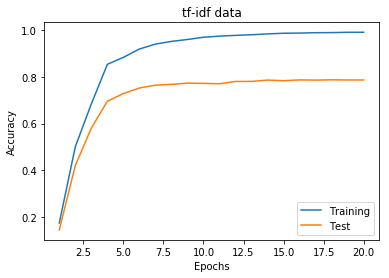

In [132]:
plt.figure()
plt.plot(range(1,num_epochs+1),acc_train2,label='Training')
# plt.plot(range(1,num_epochs+1),acc_valid2,label='Validation')
plt.plot(range(1,num_epochs+1),acc_test2,label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('tf-idf data')
plt.legend()
plt.savefig('problem2-tf-idf.pdf')
plt.show()


## Standardization

In [176]:
std_train=torch.std(news_train_inputs,0)
mean_train=torch.mean(news_train_inputs,0)

epsilon=0.00001
std_train_inputs=(news_train_inputs-mean_train)/(std_train+epsilon)
std_valid_inputs=(news_valid_inputs-mean_train)/(std_train+epsilon)
std_test_inputs=(news_test_inputs-mean_train)/(std_train+epsilon)

# from sklearn.preprocessing import StandardScaler
# standardscaler = StandardScaler(with_mean=True, with_std=True)
# standardscaler.fit(news_train_inputs.numpy())

# std_train_inputs = torch.from_numpy(standardscaler.transform(
#     news_train_inputs.numpy())).type(torch.FloatTensor) 
# std_valid_inputs = torch.from_numpy(standardscaler.transform(
#     news_valid_inputs.numpy())).type(torch.FloatTensor) 
# std_test_inputs = torch.from_numpy(standardscaler.transform(
#     news_test_inputs.numpy())).type(torch.FloatTensor) 

std_train_data  = torch.utils.data.TensorDataset(
    std_train_inputs,news_train_labels)
std_valid_data = torch.utils.data.TensorDataset(
    std_valid_inputs,news_valid_labels)
std_test_data = torch.utils.data.TensorDataset(
    std_test_inputs,news_test_labels)

print('std_train:',len(std_train_data))
print('std_valid:',len(std_valid_data))
print('std_test:',len(std_test_data))

('std_train:', 9016)
('std_valid:', 2253)
('std_test:', 7505)


In [183]:
# train model
sizes=[type_max,100,num_class]
model2 = MLPnet(sizes)
num_epochs=20
momentum=0.9
batch_size = 64
lr0 = 0.05

model2.apply(model2.init_weights_glorot)
ll_train3,ll_valid3,ll_test3,acc_train3,acc_valid3,acc_test3=\
    model2.train_model(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, std_train_data,
        std_valid_data,std_test_data,display=5)

# Epoch:20, [ACC] TRAIN 0.999334516415 / VALID 0.468708388815 / TEST 0.225716189207 lr = 0.01
# Epoch:20, [ACC] TRAIN 0.998890860692 / VALID 0.480248557479 / TEST 0.243304463691 lr = 0.005
# Epoch:20, [ACC] TRAIN 0.990017746229 / VALID 0.779405237461 / TEST 0.625716189207 lr = 0.05
# Epoch:20, [ACC] TRAIN 0.994676131322 / VALID 0.770972037284 / TEST 0.616389073951
# Epoch:20, [ACC] TRAIN 0.996339840284 / VALID 0.486462494452 / TEST 0.231179213857 lr = 0.001
# Epoch:20, [ACC] TRAIN 0.999334516415 / VALID 0.762982689747 / TEST 0.605862758161 l=0.04

('Training Begining, Count of batchs:', 141)
Epoch:1, [NLL] TRAIN [ 2086.02636719] / VALID [ 28630.1015625] / TEST [ 52496.76171875]
Epoch:1, [ACC] TRAIN 0.727706299911 / VALID 0.393697292499 / TEST 0.210393071286
Epoch:6, [NLL] TRAIN [  5.03601451e+16] / VALID [  1.06906263e+17] / TEST [  1.44989094e+17]
Epoch:6, [ACC] TRAIN 0.830301685892 / VALID 0.671992898358 / TEST 0.532978014657
Epoch:11, [NLL] TRAIN [  2.36769522e+22] / VALID [  1.10588402e+23] / TEST [  1.87051786e+23]
Epoch:11, [ACC] TRAIN 0.885425909494 / VALID 0.705725699068 / TEST 0.570419720187
Epoch:16, [NLL] TRAIN [  1.96841010e+21] / VALID [  1.15843805e+23] / TEST [  2.36305242e+23]
Epoch:16, [ACC] TRAIN 0.988464951198 / VALID 0.758100310697 / TEST 0.60546302465
Epoch:20, [NLL] TRAIN [  1.33201251e+20] / VALID [  1.16286987e+23] / TEST [  2.35605292e+23]
Epoch:20, [ACC] TRAIN 0.994121561668 / VALID 0.757212605415 / TEST 0.613857428381


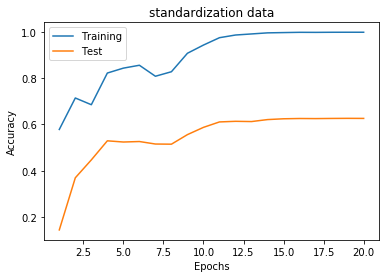

In [178]:
# plot accuracy against training time
plt.figure()
plt.plot(range(1,num_epochs+1),acc_train3,label='Training')
# plt.plot(range(1,num_epochs+1),acc_valid3,label='Validation')
plt.plot(range(1,num_epochs+1),acc_test3,label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('standardization data')
plt.legend()
plt.savefig('problem2-standardization.pdf')
plt.show()

## Variance in training

In [136]:
# mini-batch = 1
sizes=[type_max,100,num_class]
num_epochs = 60
momentum=0
lr0 = 0.15
batch_size = 1
model2 = MLPnet(sizes)
model2.apply(model2.init_weights_glorot)
ll_train1=\
    model2.train_model2(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, tfidf_train_data,
        tfidf_valid_data,display=500,record_forupdates=5000)


('Training Begining, Count of batchs:', 9016)
Update:500, [NLL] TRAIN 2.56625771523 .
Update:1000, [NLL] TRAIN 3.61144566536 .
Update:1500, [NLL] TRAIN 2.7849445343 .
Update:2000, [NLL] TRAIN 2.88969182968 .
Update:2500, [NLL] TRAIN 3.16577553749 .
Update:3000, [NLL] TRAIN 0.5741122365 .
Update:3500, [NLL] TRAIN 1.94419002533 .
Update:4000, [NLL] TRAIN 0.660029351711 .
Update:4500, [NLL] TRAIN 1.7399970293 .
Update:5000, [NLL] TRAIN 2.8030807972 .


In [137]:
# mini-batch = 100
batch_size = 100
model2.apply(model2.init_weights_glorot)
ll_train2=\
    model2.train_model2(torch.optim.SGD, lr0, momentum, 
        num_epochs, batch_size, tfidf_train_data,
        tfidf_valid_data,display=500,record_forupdates=5000)

('Training Begining, Count of batchs:', 91)
Update:500, [NLL] TRAIN 2.906011343 .
Update:1000, [NLL] TRAIN 2.81330227852 .
Update:1500, [NLL] TRAIN 2.62143301964 .
Update:2000, [NLL] TRAIN 2.49214339256 .
Update:2500, [NLL] TRAIN 2.32147550583 .
Update:3000, [NLL] TRAIN 2.2684006691 .
Update:3500, [NLL] TRAIN 2.29274201393 .
Update:4000, [NLL] TRAIN 2.108045578 .
Update:4500, [NLL] TRAIN 2.11277103424 .
Update:5000, [NLL] TRAIN 2.06383371353 .


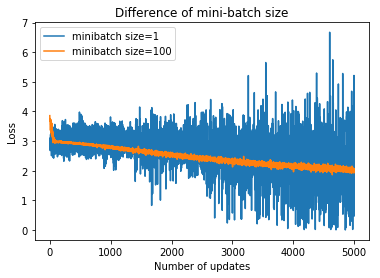

In [138]:
# plot loss on training 
plt.figure()
plt.plot(range(1,5001),ll_train1,label='minibatch size=1')
plt.plot(range(1,5001),ll_train2,label='minibatch size=100')
plt.xlabel('Number of updates')
plt.ylabel('Loss')
plt.title('Difference of mini-batch size')
plt.legend()
plt.savefig('problem2-batch_size2.pdf')
plt.show()